In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

import xgboost as xgb

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
## # step 1. prepare dataset
# def json2inputlabel(data_json, bands_type="spin up"):
#     _bands_type = {"spin up": "spin_up_bands",
#                    "spin down": "spin_down_bands",
#                    "soc": "soc_bands"}
#     data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
#     # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
#     data_label_np = np.array([data_json["new_label"]])
#     # data_label_np = np.array([data_json["layers_num"]])

#     return data_input_np, data_label_np

# step 1. prepare dataset
debug=0
def json2inputlabel(data_json, bands_type="spin up", gamma=False, layergroup_input=True):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    
#     ## Original input bands
#     data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    ## Trial: input 40*400 and take gamma point only
    data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    if gamma:
        for pts in data_json["k_labels"]:
    #         print (pts[0], pts[1])
            if pts[0] == 'G':
                if debug:
                    print (pts[0], pts[1])

    #             if pts[1] != 0:
    #                 print (f'({pts[0]}, {pts[1]}) || layers num: {data_json["layers_num"]}')
                gamma_point = pts[1]
                break


        data_input_np = data_input_np[:,gamma_point]
        if debug:
            print (f'data_input_np: {data_input_np.shape}')
            
    if layergroup_input:
        layergroup_number_input_np = np.array([data_json["layergroup_number"]])
        data_input_np = np.concatenate((data_input_np, layergroup_number_input_np), axis=None)
    ## labels
    data_label_np = np.array([data_json["new_label"]])

    return data_input_np, data_label_np

#take data and set batch size here
list_path = "./list_eigenvalue_norm_40x400_9classes"
train_dataset = AnyDataset(f"{list_path}/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset(f"{list_path}/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|███████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 606.31it/s]


Metal device set to: Apple M1 Pro


In [4]:
train_loader2 = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs,train_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in train_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

In [5]:
shape = element.numpy().shape
print (shape)
try:
    shape[2]
    element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
except IndexError:
    element_flatten2D_train = element.numpy().reshape(shape[0],shape[1])
# element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_train = labels.numpy().flatten()

dtrain = xgb.DMatrix(element_flatten2D_train, label=labels1D_train)

(1000, 4001)


In [6]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

shape = element.numpy().shape
try:
    shape[2]
    element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
except IndexError:
    element_flatten2D_test = element.numpy().reshape(shape[0],shape[1])
# shape = element.numpy().shape
# element_flatten2D_test = element.numpy().reshape(shape[0],shape[1])
# element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_test = labels.numpy().flatten()

dtest = xgb.DMatrix(element_flatten2D_test, label=labels1D_test)

In [7]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
###
# advanced: start from a initial base prediction
#
print('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
# param = {'max_depth': 5, 'eta': 0.2, 'lambda':0, 'alpha':0, 'num_class': 9, 'objective':'multi:softmax', 'sampling_method':'gradient_based'}
param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': args["load"]["numClasses"], 'objective':'multi:softmax', 'sampling_method':'gradient_based'}
# param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': 5, 'objective':'multi:softmax'}
# train xgboost for 1 round
bst = xgb.train(param, dtrain, 3500, watchlist, early_stopping_rounds=50)
# Note: we need the margin value instead of transformed prediction in
# set_base_margin
# do predict with output_margin=True, will always give you margin values
# before logistic transformation
ptrain = bst.predict(dtrain)
ptest = bst.predict(dtest)

start running example to start from a initial prediction
[02:45:49] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:2.19321	train-mlogloss:2.19032
[1]	eval-mlogloss:2.18946	train-mlogloss:2.18354
[2]	eval-mlogloss:2.18555	train-mlogloss:2.17670
[3]	eval-mlogloss:2.18175	train-mlogloss:2.16985
[4]	eval-mlogloss:2.17766	train-mlogloss:2.16298
[5]	eval-mlogloss:2.17391	train-mlogloss:2.15613
[6]	eval-mlogloss:2.16995	train-mlogloss:2.14927
[7]	eval-mlogloss:2.16617	train-mlogloss:2.14242
[8]	eval-mlogloss:2.16238	train-mlogloss:2.13568
[9]	eval-mlogloss:2.15867	train-mlogloss:2.12896
[10]	eval-mlogloss:2.15484	train-mlogloss:2.12225
[11]	eval-mlogloss:2.15125	train-mlogloss:2.11565
[12]	eval-mlogloss:2.14760	train-mlogl

[156]	eval-mlogloss:1.83261	train-mlogloss:1.43507
[157]	eval-mlogloss:1.83096	train-mlogloss:1.43162
[158]	eval-mlogloss:1.82933	train-mlogloss:1.42817
[159]	eval-mlogloss:1.82774	train-mlogloss:1.42473
[160]	eval-mlogloss:1.82610	train-mlogloss:1.42129
[161]	eval-mlogloss:1.82455	train-mlogloss:1.41787
[162]	eval-mlogloss:1.82296	train-mlogloss:1.41447
[163]	eval-mlogloss:1.82137	train-mlogloss:1.41110
[164]	eval-mlogloss:1.81980	train-mlogloss:1.40772
[165]	eval-mlogloss:1.81806	train-mlogloss:1.40435
[166]	eval-mlogloss:1.81646	train-mlogloss:1.40098
[167]	eval-mlogloss:1.81476	train-mlogloss:1.39766
[168]	eval-mlogloss:1.81315	train-mlogloss:1.39432
[169]	eval-mlogloss:1.81156	train-mlogloss:1.39101
[170]	eval-mlogloss:1.80993	train-mlogloss:1.38770
[171]	eval-mlogloss:1.80842	train-mlogloss:1.38441
[172]	eval-mlogloss:1.80673	train-mlogloss:1.38111
[173]	eval-mlogloss:1.80506	train-mlogloss:1.37784
[174]	eval-mlogloss:1.80363	train-mlogloss:1.37458
[175]	eval-mlogloss:1.80205	tra

[317]	eval-mlogloss:1.62259	train-mlogloss:1.00066
[318]	eval-mlogloss:1.62159	train-mlogloss:0.99856
[319]	eval-mlogloss:1.62063	train-mlogloss:0.99646
[320]	eval-mlogloss:1.61962	train-mlogloss:0.99435
[321]	eval-mlogloss:1.61865	train-mlogloss:0.99228
[322]	eval-mlogloss:1.61758	train-mlogloss:0.99018
[323]	eval-mlogloss:1.61667	train-mlogloss:0.98811
[324]	eval-mlogloss:1.61566	train-mlogloss:0.98603
[325]	eval-mlogloss:1.61469	train-mlogloss:0.98396
[326]	eval-mlogloss:1.61364	train-mlogloss:0.98188
[327]	eval-mlogloss:1.61278	train-mlogloss:0.97982
[328]	eval-mlogloss:1.61171	train-mlogloss:0.97776
[329]	eval-mlogloss:1.61077	train-mlogloss:0.97571
[330]	eval-mlogloss:1.60983	train-mlogloss:0.97366
[331]	eval-mlogloss:1.60885	train-mlogloss:0.97160
[332]	eval-mlogloss:1.60796	train-mlogloss:0.96957
[333]	eval-mlogloss:1.60697	train-mlogloss:0.96753
[334]	eval-mlogloss:1.60610	train-mlogloss:0.96550
[335]	eval-mlogloss:1.60512	train-mlogloss:0.96347
[336]	eval-mlogloss:1.60429	tra

[478]	eval-mlogloss:1.49603	train-mlogloss:0.72330
[479]	eval-mlogloss:1.49533	train-mlogloss:0.72191
[480]	eval-mlogloss:1.49465	train-mlogloss:0.72050
[481]	eval-mlogloss:1.49390	train-mlogloss:0.71910
[482]	eval-mlogloss:1.49324	train-mlogloss:0.71770
[483]	eval-mlogloss:1.49255	train-mlogloss:0.71630
[484]	eval-mlogloss:1.49185	train-mlogloss:0.71491
[485]	eval-mlogloss:1.49123	train-mlogloss:0.71352
[486]	eval-mlogloss:1.49049	train-mlogloss:0.71214
[487]	eval-mlogloss:1.48984	train-mlogloss:0.71076
[488]	eval-mlogloss:1.48917	train-mlogloss:0.70939
[489]	eval-mlogloss:1.48852	train-mlogloss:0.70800
[490]	eval-mlogloss:1.48781	train-mlogloss:0.70662
[491]	eval-mlogloss:1.48708	train-mlogloss:0.70526
[492]	eval-mlogloss:1.48644	train-mlogloss:0.70391
[493]	eval-mlogloss:1.48575	train-mlogloss:0.70255
[494]	eval-mlogloss:1.48504	train-mlogloss:0.70120
[495]	eval-mlogloss:1.48440	train-mlogloss:0.69985
[496]	eval-mlogloss:1.48372	train-mlogloss:0.69851
[497]	eval-mlogloss:1.48298	tra

[639]	eval-mlogloss:1.40271	train-mlogloss:0.53411
[640]	eval-mlogloss:1.40221	train-mlogloss:0.53313
[641]	eval-mlogloss:1.40173	train-mlogloss:0.53216
[642]	eval-mlogloss:1.40128	train-mlogloss:0.53119
[643]	eval-mlogloss:1.40074	train-mlogloss:0.53021
[644]	eval-mlogloss:1.40028	train-mlogloss:0.52924
[645]	eval-mlogloss:1.39981	train-mlogloss:0.52827
[646]	eval-mlogloss:1.39933	train-mlogloss:0.52730
[647]	eval-mlogloss:1.39890	train-mlogloss:0.52633
[648]	eval-mlogloss:1.39835	train-mlogloss:0.52537
[649]	eval-mlogloss:1.39797	train-mlogloss:0.52441
[650]	eval-mlogloss:1.39753	train-mlogloss:0.52345
[651]	eval-mlogloss:1.39713	train-mlogloss:0.52249
[652]	eval-mlogloss:1.39668	train-mlogloss:0.52154
[653]	eval-mlogloss:1.39615	train-mlogloss:0.52058
[654]	eval-mlogloss:1.39571	train-mlogloss:0.51963
[655]	eval-mlogloss:1.39526	train-mlogloss:0.51869
[656]	eval-mlogloss:1.39485	train-mlogloss:0.51774
[657]	eval-mlogloss:1.39440	train-mlogloss:0.51680
[658]	eval-mlogloss:1.39398	tra

[800]	eval-mlogloss:1.34012	train-mlogloss:0.39880
[801]	eval-mlogloss:1.33972	train-mlogloss:0.39808
[802]	eval-mlogloss:1.33932	train-mlogloss:0.39737
[803]	eval-mlogloss:1.33897	train-mlogloss:0.39665
[804]	eval-mlogloss:1.33860	train-mlogloss:0.39595
[805]	eval-mlogloss:1.33815	train-mlogloss:0.39523
[806]	eval-mlogloss:1.33779	train-mlogloss:0.39452
[807]	eval-mlogloss:1.33747	train-mlogloss:0.39382
[808]	eval-mlogloss:1.33706	train-mlogloss:0.39311
[809]	eval-mlogloss:1.33671	train-mlogloss:0.39241
[810]	eval-mlogloss:1.33630	train-mlogloss:0.39171
[811]	eval-mlogloss:1.33592	train-mlogloss:0.39101
[812]	eval-mlogloss:1.33553	train-mlogloss:0.39031
[813]	eval-mlogloss:1.33519	train-mlogloss:0.38961
[814]	eval-mlogloss:1.33485	train-mlogloss:0.38892
[815]	eval-mlogloss:1.33445	train-mlogloss:0.38822
[816]	eval-mlogloss:1.33414	train-mlogloss:0.38753
[817]	eval-mlogloss:1.33383	train-mlogloss:0.38684
[818]	eval-mlogloss:1.33348	train-mlogloss:0.38616
[819]	eval-mlogloss:1.33313	tra

[961]	eval-mlogloss:1.29238	train-mlogloss:0.30100
[962]	eval-mlogloss:1.29218	train-mlogloss:0.30049
[963]	eval-mlogloss:1.29195	train-mlogloss:0.29997
[964]	eval-mlogloss:1.29171	train-mlogloss:0.29946
[965]	eval-mlogloss:1.29149	train-mlogloss:0.29894
[966]	eval-mlogloss:1.29121	train-mlogloss:0.29843
[967]	eval-mlogloss:1.29087	train-mlogloss:0.29791
[968]	eval-mlogloss:1.29059	train-mlogloss:0.29740
[969]	eval-mlogloss:1.29039	train-mlogloss:0.29689
[970]	eval-mlogloss:1.29021	train-mlogloss:0.29637
[971]	eval-mlogloss:1.28997	train-mlogloss:0.29586
[972]	eval-mlogloss:1.28965	train-mlogloss:0.29535
[973]	eval-mlogloss:1.28934	train-mlogloss:0.29485
[974]	eval-mlogloss:1.28900	train-mlogloss:0.29434
[975]	eval-mlogloss:1.28881	train-mlogloss:0.29383
[976]	eval-mlogloss:1.28853	train-mlogloss:0.29333
[977]	eval-mlogloss:1.28830	train-mlogloss:0.29282
[978]	eval-mlogloss:1.28803	train-mlogloss:0.29231
[979]	eval-mlogloss:1.28774	train-mlogloss:0.29181
[980]	eval-mlogloss:1.28744	tra

[1120]	eval-mlogloss:1.24904	train-mlogloss:0.23002
[1121]	eval-mlogloss:1.24872	train-mlogloss:0.22964
[1122]	eval-mlogloss:1.24841	train-mlogloss:0.22926
[1123]	eval-mlogloss:1.24820	train-mlogloss:0.22888
[1124]	eval-mlogloss:1.24801	train-mlogloss:0.22850
[1125]	eval-mlogloss:1.24779	train-mlogloss:0.22812
[1126]	eval-mlogloss:1.24749	train-mlogloss:0.22774
[1127]	eval-mlogloss:1.24719	train-mlogloss:0.22736
[1128]	eval-mlogloss:1.24697	train-mlogloss:0.22699
[1129]	eval-mlogloss:1.24674	train-mlogloss:0.22662
[1130]	eval-mlogloss:1.24655	train-mlogloss:0.22624
[1131]	eval-mlogloss:1.24633	train-mlogloss:0.22586
[1132]	eval-mlogloss:1.24603	train-mlogloss:0.22549
[1133]	eval-mlogloss:1.24577	train-mlogloss:0.22512
[1134]	eval-mlogloss:1.24555	train-mlogloss:0.22475
[1135]	eval-mlogloss:1.24525	train-mlogloss:0.22438
[1136]	eval-mlogloss:1.24500	train-mlogloss:0.22401
[1137]	eval-mlogloss:1.24474	train-mlogloss:0.22364
[1138]	eval-mlogloss:1.24449	train-mlogloss:0.22327
[1139]	eval-

[1278]	eval-mlogloss:1.21353	train-mlogloss:0.17805
[1279]	eval-mlogloss:1.21335	train-mlogloss:0.17776
[1280]	eval-mlogloss:1.21314	train-mlogloss:0.17749
[1281]	eval-mlogloss:1.21296	train-mlogloss:0.17721
[1282]	eval-mlogloss:1.21285	train-mlogloss:0.17693
[1283]	eval-mlogloss:1.21266	train-mlogloss:0.17665
[1284]	eval-mlogloss:1.21250	train-mlogloss:0.17638
[1285]	eval-mlogloss:1.21226	train-mlogloss:0.17610
[1286]	eval-mlogloss:1.21214	train-mlogloss:0.17582
[1287]	eval-mlogloss:1.21193	train-mlogloss:0.17555
[1288]	eval-mlogloss:1.21181	train-mlogloss:0.17527
[1289]	eval-mlogloss:1.21159	train-mlogloss:0.17500
[1290]	eval-mlogloss:1.21148	train-mlogloss:0.17472
[1291]	eval-mlogloss:1.21129	train-mlogloss:0.17445
[1292]	eval-mlogloss:1.21107	train-mlogloss:0.17418
[1293]	eval-mlogloss:1.21096	train-mlogloss:0.17391
[1294]	eval-mlogloss:1.21078	train-mlogloss:0.17363
[1295]	eval-mlogloss:1.21062	train-mlogloss:0.17336
[1296]	eval-mlogloss:1.21050	train-mlogloss:0.17310
[1297]	eval-

[1436]	eval-mlogloss:1.18665	train-mlogloss:0.13975
[1437]	eval-mlogloss:1.18645	train-mlogloss:0.13955
[1438]	eval-mlogloss:1.18631	train-mlogloss:0.13934
[1439]	eval-mlogloss:1.18609	train-mlogloss:0.13913
[1440]	eval-mlogloss:1.18597	train-mlogloss:0.13893
[1441]	eval-mlogloss:1.18587	train-mlogloss:0.13872
[1442]	eval-mlogloss:1.18568	train-mlogloss:0.13851
[1443]	eval-mlogloss:1.18553	train-mlogloss:0.13831
[1444]	eval-mlogloss:1.18538	train-mlogloss:0.13810
[1445]	eval-mlogloss:1.18520	train-mlogloss:0.13790
[1446]	eval-mlogloss:1.18503	train-mlogloss:0.13770
[1447]	eval-mlogloss:1.18490	train-mlogloss:0.13749
[1448]	eval-mlogloss:1.18471	train-mlogloss:0.13729
[1449]	eval-mlogloss:1.18455	train-mlogloss:0.13709
[1450]	eval-mlogloss:1.18437	train-mlogloss:0.13689
[1451]	eval-mlogloss:1.18425	train-mlogloss:0.13669
[1452]	eval-mlogloss:1.18405	train-mlogloss:0.13648
[1453]	eval-mlogloss:1.18390	train-mlogloss:0.13628
[1454]	eval-mlogloss:1.18368	train-mlogloss:0.13608
[1455]	eval-

[1594]	eval-mlogloss:1.16177	train-mlogloss:0.11130
[1595]	eval-mlogloss:1.16164	train-mlogloss:0.11114
[1596]	eval-mlogloss:1.16152	train-mlogloss:0.11099
[1597]	eval-mlogloss:1.16141	train-mlogloss:0.11083
[1598]	eval-mlogloss:1.16131	train-mlogloss:0.11068
[1599]	eval-mlogloss:1.16116	train-mlogloss:0.11052
[1600]	eval-mlogloss:1.16103	train-mlogloss:0.11037
[1601]	eval-mlogloss:1.16091	train-mlogloss:0.11021
[1602]	eval-mlogloss:1.16081	train-mlogloss:0.11006
[1603]	eval-mlogloss:1.16073	train-mlogloss:0.10990
[1604]	eval-mlogloss:1.16058	train-mlogloss:0.10975
[1605]	eval-mlogloss:1.16050	train-mlogloss:0.10960
[1606]	eval-mlogloss:1.16030	train-mlogloss:0.10944
[1607]	eval-mlogloss:1.16013	train-mlogloss:0.10929
[1608]	eval-mlogloss:1.16002	train-mlogloss:0.10914
[1609]	eval-mlogloss:1.15991	train-mlogloss:0.10898
[1610]	eval-mlogloss:1.15978	train-mlogloss:0.10884
[1611]	eval-mlogloss:1.15965	train-mlogloss:0.10868
[1612]	eval-mlogloss:1.15951	train-mlogloss:0.10853
[1613]	eval-

[1752]	eval-mlogloss:1.14870	train-mlogloss:0.08997
[1753]	eval-mlogloss:1.14861	train-mlogloss:0.08986
[1754]	eval-mlogloss:1.14857	train-mlogloss:0.08974
[1755]	eval-mlogloss:1.14853	train-mlogloss:0.08962
[1756]	eval-mlogloss:1.14838	train-mlogloss:0.08951
[1757]	eval-mlogloss:1.14833	train-mlogloss:0.08940
[1758]	eval-mlogloss:1.14827	train-mlogloss:0.08928
[1759]	eval-mlogloss:1.14819	train-mlogloss:0.08917
[1760]	eval-mlogloss:1.14815	train-mlogloss:0.08905
[1761]	eval-mlogloss:1.14802	train-mlogloss:0.08894
[1762]	eval-mlogloss:1.14790	train-mlogloss:0.08882
[1763]	eval-mlogloss:1.14785	train-mlogloss:0.08871
[1764]	eval-mlogloss:1.14776	train-mlogloss:0.08860
[1765]	eval-mlogloss:1.14767	train-mlogloss:0.08848
[1766]	eval-mlogloss:1.14761	train-mlogloss:0.08837
[1767]	eval-mlogloss:1.14752	train-mlogloss:0.08826
[1768]	eval-mlogloss:1.14743	train-mlogloss:0.08814
[1769]	eval-mlogloss:1.14742	train-mlogloss:0.08803
[1770]	eval-mlogloss:1.14727	train-mlogloss:0.08792
[1771]	eval-

[1910]	eval-mlogloss:1.13737	train-mlogloss:0.07394
[1911]	eval-mlogloss:1.13727	train-mlogloss:0.07385
[1912]	eval-mlogloss:1.13723	train-mlogloss:0.07376
[1913]	eval-mlogloss:1.13712	train-mlogloss:0.07368
[1914]	eval-mlogloss:1.13708	train-mlogloss:0.07359
[1915]	eval-mlogloss:1.13692	train-mlogloss:0.07350
[1916]	eval-mlogloss:1.13692	train-mlogloss:0.07341
[1917]	eval-mlogloss:1.13687	train-mlogloss:0.07332
[1918]	eval-mlogloss:1.13680	train-mlogloss:0.07323
[1919]	eval-mlogloss:1.13674	train-mlogloss:0.07315
[1920]	eval-mlogloss:1.13659	train-mlogloss:0.07306
[1921]	eval-mlogloss:1.13647	train-mlogloss:0.07297
[1922]	eval-mlogloss:1.13639	train-mlogloss:0.07288
[1923]	eval-mlogloss:1.13631	train-mlogloss:0.07280
[1924]	eval-mlogloss:1.13624	train-mlogloss:0.07271
[1925]	eval-mlogloss:1.13617	train-mlogloss:0.07262
[1926]	eval-mlogloss:1.13612	train-mlogloss:0.07254
[1927]	eval-mlogloss:1.13594	train-mlogloss:0.07245
[1928]	eval-mlogloss:1.13591	train-mlogloss:0.07236
[1929]	eval-

[2068]	eval-mlogloss:1.12589	train-mlogloss:0.06155
[2069]	eval-mlogloss:1.12582	train-mlogloss:0.06148
[2070]	eval-mlogloss:1.12573	train-mlogloss:0.06141
[2071]	eval-mlogloss:1.12560	train-mlogloss:0.06134
[2072]	eval-mlogloss:1.12553	train-mlogloss:0.06127
[2073]	eval-mlogloss:1.12542	train-mlogloss:0.06120
[2074]	eval-mlogloss:1.12534	train-mlogloss:0.06113
[2075]	eval-mlogloss:1.12525	train-mlogloss:0.06107
[2076]	eval-mlogloss:1.12519	train-mlogloss:0.06100
[2077]	eval-mlogloss:1.12519	train-mlogloss:0.06093
[2078]	eval-mlogloss:1.12508	train-mlogloss:0.06086
[2079]	eval-mlogloss:1.12504	train-mlogloss:0.06079
[2080]	eval-mlogloss:1.12505	train-mlogloss:0.06073
[2081]	eval-mlogloss:1.12501	train-mlogloss:0.06066
[2082]	eval-mlogloss:1.12496	train-mlogloss:0.06059
[2083]	eval-mlogloss:1.12490	train-mlogloss:0.06052
[2084]	eval-mlogloss:1.12480	train-mlogloss:0.06045
[2085]	eval-mlogloss:1.12477	train-mlogloss:0.06039
[2086]	eval-mlogloss:1.12473	train-mlogloss:0.06032
[2087]	eval-

[2226]	eval-mlogloss:1.11617	train-mlogloss:0.05191
[2227]	eval-mlogloss:1.11615	train-mlogloss:0.05186
[2228]	eval-mlogloss:1.11612	train-mlogloss:0.05181
[2229]	eval-mlogloss:1.11611	train-mlogloss:0.05175
[2230]	eval-mlogloss:1.11604	train-mlogloss:0.05170
[2231]	eval-mlogloss:1.11600	train-mlogloss:0.05165
[2232]	eval-mlogloss:1.11598	train-mlogloss:0.05159
[2233]	eval-mlogloss:1.11594	train-mlogloss:0.05154
[2234]	eval-mlogloss:1.11591	train-mlogloss:0.05149
[2235]	eval-mlogloss:1.11589	train-mlogloss:0.05144
[2236]	eval-mlogloss:1.11587	train-mlogloss:0.05139
[2237]	eval-mlogloss:1.11583	train-mlogloss:0.05133
[2238]	eval-mlogloss:1.11577	train-mlogloss:0.05128
[2239]	eval-mlogloss:1.11575	train-mlogloss:0.05123
[2240]	eval-mlogloss:1.11570	train-mlogloss:0.05118
[2241]	eval-mlogloss:1.11568	train-mlogloss:0.05112
[2242]	eval-mlogloss:1.11560	train-mlogloss:0.05108
[2243]	eval-mlogloss:1.11556	train-mlogloss:0.05102
[2244]	eval-mlogloss:1.11556	train-mlogloss:0.05097
[2245]	eval-

[2384]	eval-mlogloss:1.11117	train-mlogloss:0.04447
[2385]	eval-mlogloss:1.11115	train-mlogloss:0.04443
[2386]	eval-mlogloss:1.11112	train-mlogloss:0.04439
[2387]	eval-mlogloss:1.11109	train-mlogloss:0.04435
[2388]	eval-mlogloss:1.11107	train-mlogloss:0.04431
[2389]	eval-mlogloss:1.11110	train-mlogloss:0.04427
[2390]	eval-mlogloss:1.11105	train-mlogloss:0.04423
[2391]	eval-mlogloss:1.11103	train-mlogloss:0.04419
[2392]	eval-mlogloss:1.11103	train-mlogloss:0.04414
[2393]	eval-mlogloss:1.11098	train-mlogloss:0.04410
[2394]	eval-mlogloss:1.11098	train-mlogloss:0.04407
[2395]	eval-mlogloss:1.11097	train-mlogloss:0.04403
[2396]	eval-mlogloss:1.11095	train-mlogloss:0.04399
[2397]	eval-mlogloss:1.11088	train-mlogloss:0.04395
[2398]	eval-mlogloss:1.11089	train-mlogloss:0.04391
[2399]	eval-mlogloss:1.11085	train-mlogloss:0.04387
[2400]	eval-mlogloss:1.11088	train-mlogloss:0.04383
[2401]	eval-mlogloss:1.11089	train-mlogloss:0.04378
[2402]	eval-mlogloss:1.11086	train-mlogloss:0.04374
[2403]	eval-

[2542]	eval-mlogloss:1.10915	train-mlogloss:0.03881
[2543]	eval-mlogloss:1.10918	train-mlogloss:0.03878
[2544]	eval-mlogloss:1.10916	train-mlogloss:0.03875
[2545]	eval-mlogloss:1.10919	train-mlogloss:0.03872
[2546]	eval-mlogloss:1.10919	train-mlogloss:0.03868
[2547]	eval-mlogloss:1.10912	train-mlogloss:0.03865
[2548]	eval-mlogloss:1.10913	train-mlogloss:0.03862
[2549]	eval-mlogloss:1.10915	train-mlogloss:0.03859
[2550]	eval-mlogloss:1.10911	train-mlogloss:0.03856
[2551]	eval-mlogloss:1.10913	train-mlogloss:0.03852
[2552]	eval-mlogloss:1.10911	train-mlogloss:0.03849
[2553]	eval-mlogloss:1.10911	train-mlogloss:0.03846
[2554]	eval-mlogloss:1.10914	train-mlogloss:0.03843
[2555]	eval-mlogloss:1.10911	train-mlogloss:0.03840
[2556]	eval-mlogloss:1.10910	train-mlogloss:0.03837
[2557]	eval-mlogloss:1.10909	train-mlogloss:0.03834
[2558]	eval-mlogloss:1.10909	train-mlogloss:0.03830
[2559]	eval-mlogloss:1.10908	train-mlogloss:0.03827
[2560]	eval-mlogloss:1.10910	train-mlogloss:0.03824
[2561]	eval-

[2700]	eval-mlogloss:1.10757	train-mlogloss:0.03420
[2701]	eval-mlogloss:1.10755	train-mlogloss:0.03418
[2702]	eval-mlogloss:1.10752	train-mlogloss:0.03415
[2703]	eval-mlogloss:1.10752	train-mlogloss:0.03412
[2704]	eval-mlogloss:1.10747	train-mlogloss:0.03410
[2705]	eval-mlogloss:1.10746	train-mlogloss:0.03407
[2706]	eval-mlogloss:1.10747	train-mlogloss:0.03405
[2707]	eval-mlogloss:1.10747	train-mlogloss:0.03402
[2708]	eval-mlogloss:1.10749	train-mlogloss:0.03399
[2709]	eval-mlogloss:1.10747	train-mlogloss:0.03397
[2710]	eval-mlogloss:1.10748	train-mlogloss:0.03395
[2711]	eval-mlogloss:1.10744	train-mlogloss:0.03392
[2712]	eval-mlogloss:1.10743	train-mlogloss:0.03390
[2713]	eval-mlogloss:1.10744	train-mlogloss:0.03387
[2714]	eval-mlogloss:1.10749	train-mlogloss:0.03384
[2715]	eval-mlogloss:1.10749	train-mlogloss:0.03382
[2716]	eval-mlogloss:1.10748	train-mlogloss:0.03379
[2717]	eval-mlogloss:1.10744	train-mlogloss:0.03377
[2718]	eval-mlogloss:1.10740	train-mlogloss:0.03374
[2719]	eval-

[2858]	eval-mlogloss:1.10903	train-mlogloss:0.03057
[2859]	eval-mlogloss:1.10912	train-mlogloss:0.03055
[2860]	eval-mlogloss:1.10916	train-mlogloss:0.03053
[2861]	eval-mlogloss:1.10923	train-mlogloss:0.03051
[2862]	eval-mlogloss:1.10924	train-mlogloss:0.03049
[2863]	eval-mlogloss:1.10923	train-mlogloss:0.03047
[2864]	eval-mlogloss:1.10925	train-mlogloss:0.03045
[2865]	eval-mlogloss:1.10925	train-mlogloss:0.03043
[2866]	eval-mlogloss:1.10927	train-mlogloss:0.03041
[2867]	eval-mlogloss:1.10924	train-mlogloss:0.03039
[2868]	eval-mlogloss:1.10928	train-mlogloss:0.03037
[2869]	eval-mlogloss:1.10934	train-mlogloss:0.03035
[2870]	eval-mlogloss:1.10933	train-mlogloss:0.03033
[2871]	eval-mlogloss:1.10933	train-mlogloss:0.03031
[2872]	eval-mlogloss:1.10931	train-mlogloss:0.03029
[2873]	eval-mlogloss:1.10939	train-mlogloss:0.03027
[2874]	eval-mlogloss:1.10934	train-mlogloss:0.03025
[2875]	eval-mlogloss:1.10933	train-mlogloss:0.03022
[2876]	eval-mlogloss:1.10931	train-mlogloss:0.03020
[2877]	eval-

[3016]	eval-mlogloss:1.10837	train-mlogloss:0.02757
[3017]	eval-mlogloss:1.10835	train-mlogloss:0.02756
[3018]	eval-mlogloss:1.10834	train-mlogloss:0.02754
[3019]	eval-mlogloss:1.10843	train-mlogloss:0.02752
[3020]	eval-mlogloss:1.10842	train-mlogloss:0.02751
[3021]	eval-mlogloss:1.10846	train-mlogloss:0.02749
[3022]	eval-mlogloss:1.10845	train-mlogloss:0.02747
[3023]	eval-mlogloss:1.10852	train-mlogloss:0.02746
[3024]	eval-mlogloss:1.10846	train-mlogloss:0.02744
[3025]	eval-mlogloss:1.10850	train-mlogloss:0.02742
[3026]	eval-mlogloss:1.10854	train-mlogloss:0.02741
[3027]	eval-mlogloss:1.10854	train-mlogloss:0.02739
[3028]	eval-mlogloss:1.10857	train-mlogloss:0.02737
[3029]	eval-mlogloss:1.10859	train-mlogloss:0.02736
[3030]	eval-mlogloss:1.10867	train-mlogloss:0.02734
[3031]	eval-mlogloss:1.10866	train-mlogloss:0.02732
[3032]	eval-mlogloss:1.10867	train-mlogloss:0.02731
[3033]	eval-mlogloss:1.10870	train-mlogloss:0.02729
[3034]	eval-mlogloss:1.10871	train-mlogloss:0.02728
[3035]	eval-

[3174]	eval-mlogloss:1.11468	train-mlogloss:0.02520
[3175]	eval-mlogloss:1.11474	train-mlogloss:0.02518
[3176]	eval-mlogloss:1.11478	train-mlogloss:0.02517
[3177]	eval-mlogloss:1.11483	train-mlogloss:0.02516
[3178]	eval-mlogloss:1.11484	train-mlogloss:0.02514
[3179]	eval-mlogloss:1.11485	train-mlogloss:0.02513
[3180]	eval-mlogloss:1.11484	train-mlogloss:0.02511
[3181]	eval-mlogloss:1.11495	train-mlogloss:0.02510
[3182]	eval-mlogloss:1.11501	train-mlogloss:0.02509
[3183]	eval-mlogloss:1.11501	train-mlogloss:0.02508
[3184]	eval-mlogloss:1.11507	train-mlogloss:0.02506
[3185]	eval-mlogloss:1.11513	train-mlogloss:0.02505
[3186]	eval-mlogloss:1.11518	train-mlogloss:0.02504
[3187]	eval-mlogloss:1.11516	train-mlogloss:0.02502
[3188]	eval-mlogloss:1.11519	train-mlogloss:0.02501
[3189]	eval-mlogloss:1.11527	train-mlogloss:0.02499
[3190]	eval-mlogloss:1.11533	train-mlogloss:0.02498
[3191]	eval-mlogloss:1.11535	train-mlogloss:0.02497
[3192]	eval-mlogloss:1.11538	train-mlogloss:0.02496
[3193]	eval-

[3332]	eval-mlogloss:1.12088	train-mlogloss:0.02333
[3333]	eval-mlogloss:1.12093	train-mlogloss:0.02332
[3334]	eval-mlogloss:1.12102	train-mlogloss:0.02331
[3335]	eval-mlogloss:1.12107	train-mlogloss:0.02330
[3336]	eval-mlogloss:1.12112	train-mlogloss:0.02329
[3337]	eval-mlogloss:1.12118	train-mlogloss:0.02328
[3338]	eval-mlogloss:1.12125	train-mlogloss:0.02327
[3339]	eval-mlogloss:1.12128	train-mlogloss:0.02326
[3340]	eval-mlogloss:1.12135	train-mlogloss:0.02325
[3341]	eval-mlogloss:1.12142	train-mlogloss:0.02324
[3342]	eval-mlogloss:1.12148	train-mlogloss:0.02323
[3343]	eval-mlogloss:1.12154	train-mlogloss:0.02322
[3344]	eval-mlogloss:1.12161	train-mlogloss:0.02321
[3345]	eval-mlogloss:1.12164	train-mlogloss:0.02320
[3346]	eval-mlogloss:1.12169	train-mlogloss:0.02319
[3347]	eval-mlogloss:1.12178	train-mlogloss:0.02318
[3348]	eval-mlogloss:1.12185	train-mlogloss:0.02317
[3349]	eval-mlogloss:1.12190	train-mlogloss:0.02315
[3350]	eval-mlogloss:1.12193	train-mlogloss:0.02314
[3351]	eval-

[3490]	eval-mlogloss:1.12900	train-mlogloss:0.02179
[3491]	eval-mlogloss:1.12904	train-mlogloss:0.02179
[3492]	eval-mlogloss:1.12905	train-mlogloss:0.02178
[3493]	eval-mlogloss:1.12912	train-mlogloss:0.02177
[3494]	eval-mlogloss:1.12913	train-mlogloss:0.02176
[3495]	eval-mlogloss:1.12922	train-mlogloss:0.02175
[3496]	eval-mlogloss:1.12926	train-mlogloss:0.02174
[3497]	eval-mlogloss:1.12932	train-mlogloss:0.02173
[3498]	eval-mlogloss:1.12932	train-mlogloss:0.02173
[3499]	eval-mlogloss:1.12939	train-mlogloss:0.02172


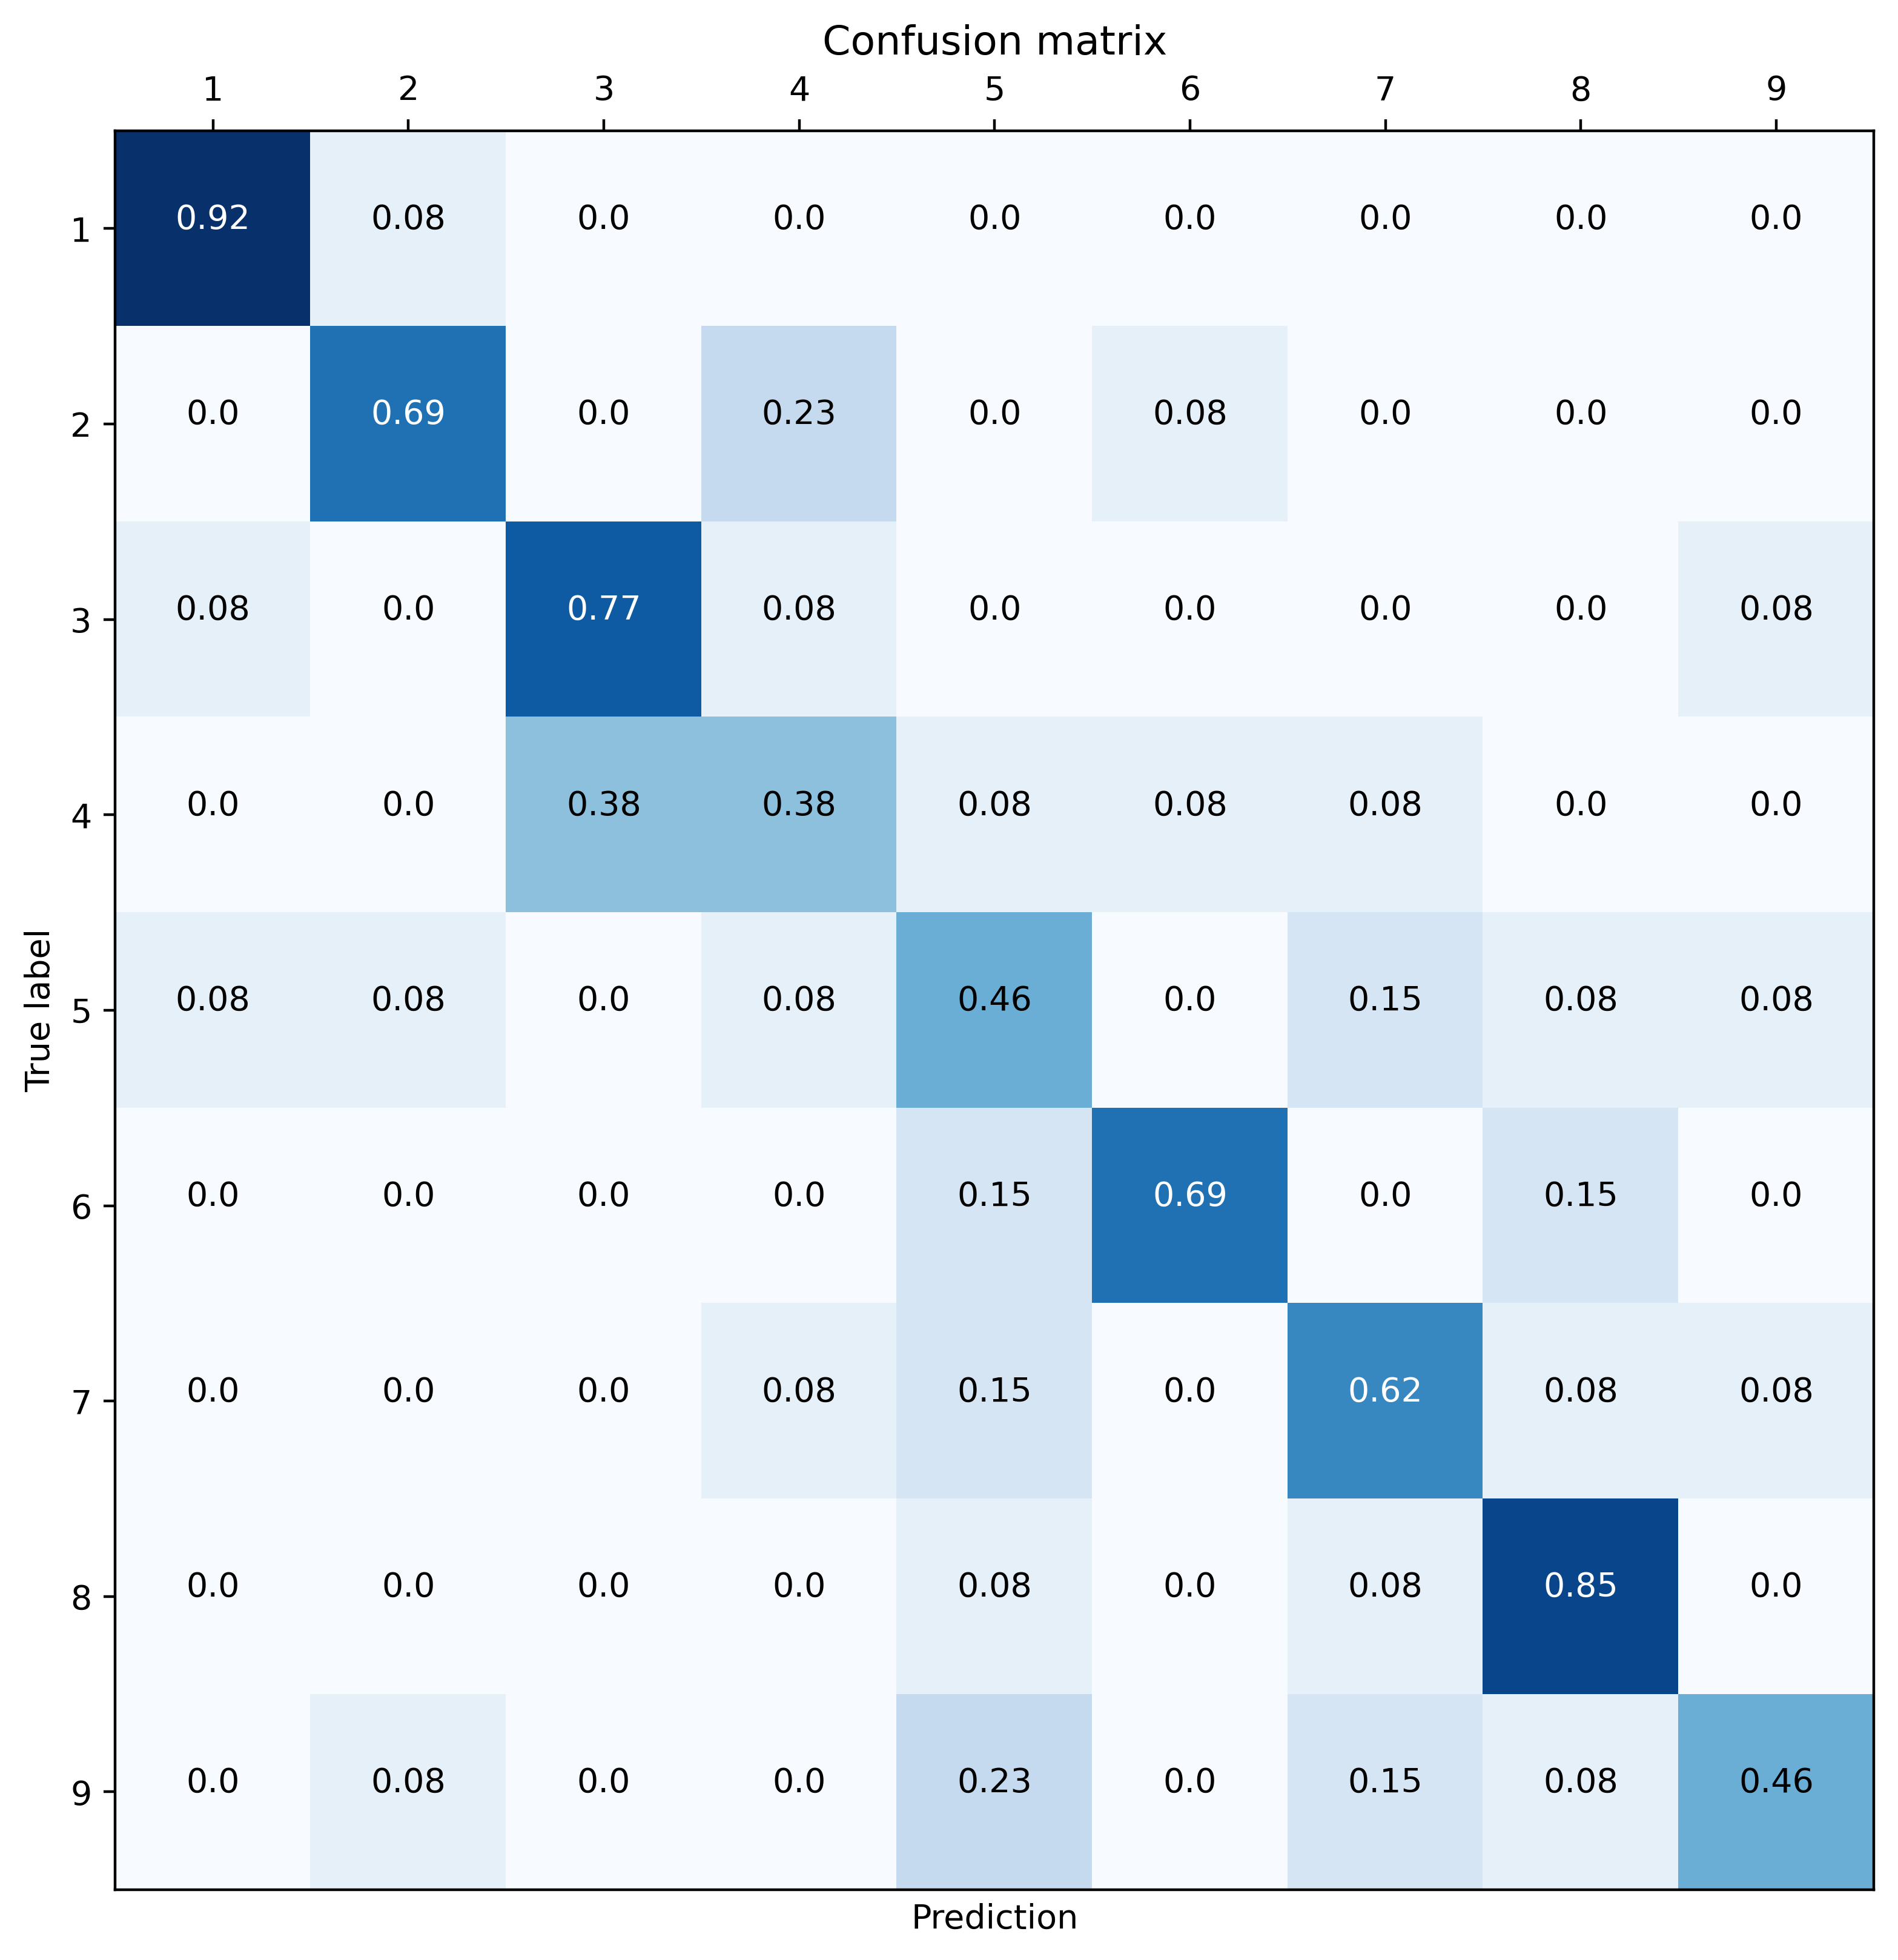

In [8]:
# confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=[3, 4, 5, 6, 7])
confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=np.arange(1,10,1).tolist())

In [9]:
# m = tf.keras.metrics.SparseCategoricalAccuracy()
# m.update_state(labels1D_test.reshape(1,100).shape, ptest.reshape(1,100).shape)
# m.result().numpy()

In [10]:
from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=labels1D_test, y_pred=ptest)
mse
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# print (test_accuracy(labels1D_test.reshape(labels1D_test.shape[0],1), ptest.reshape(ptest.shape[0],1)))

0.6495726495726496

<Figure size 4800x4000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 4800x4000 with 0 Axes>

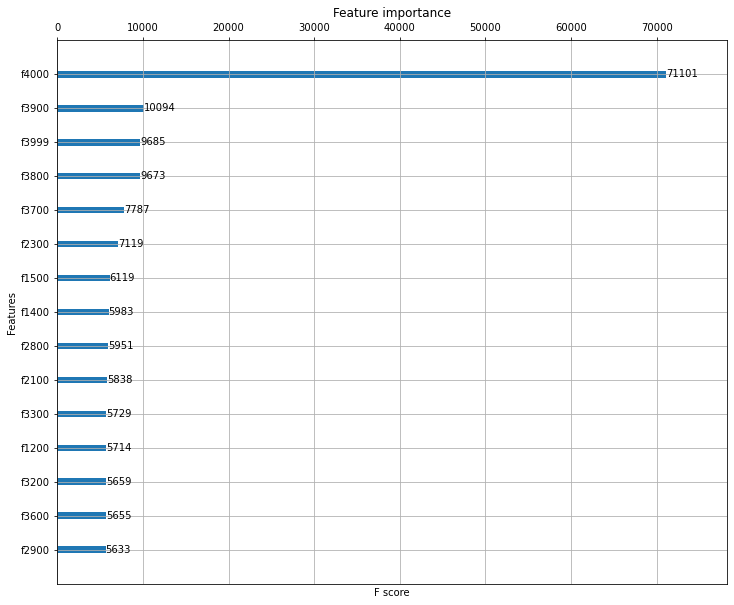

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10
plt.figure(dpi=400)
xgb.plot_importance(bst, max_num_features=15)

<Figure size 80000x50000 with 0 Axes>

<AxesSubplot:>

<Figure size 80000x50000 with 0 Axes>

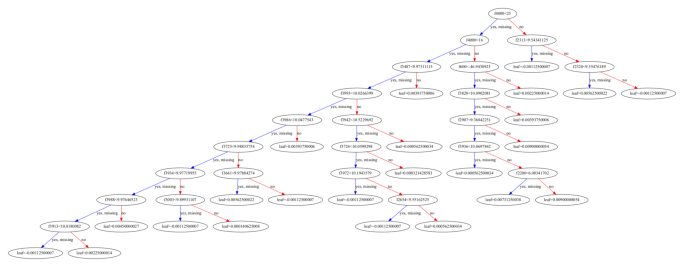

In [21]:
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 80,50
plt.figure(figsize=(80, 50), dpi=1000)
xgb.plot_tree(bst, num_trees=5)

In [13]:
element_flatten2D_test[:,-1]
labels1D_test
ptest

array([72., 78., 23., 69.,  2., 78., 78.,  2.,  4.,  1.,  8.,  2., 78.,
       23., 78., 23., 80., 37., 80.,  2., 23., 69., 78., 78., 14., 68.,
       68.,  2., 72.,  1.,  2.,  2., 23.,  2.,  1.,  1.,  8.,  2.,  2.,
        4., 72., 23.,  2.,  1.,  1., 37., 37.,  2., 78., 59.,  1., 72.,
       41.,  1., 23., 80., 72.,  1., 51.,  1.,  2., 72.,  2.,  2., 69.,
        2.,  2., 78., 69.,  2., 78.,  1., 28.,  1., 11., 78., 78., 80.,
       78., 59., 78., 78.,  1., 72., 69., 72.,  2., 72., 78.,  2.,  1.,
       78.,  1.,  6., 72., 46., 78.,  1., 59.,  4., 69., 78., 23.,  8.,
       78., 50., 23.,  2., 78., 72., 78.,  4., 69., 23., 69., 72.,  2.])

array([3, 3, 5, 2, 1, 2, 1, 7, 8, 8, 4, 1, 3, 5, 3, 3, 0, 0, 0, 3, 5, 1,
       2, 2, 1, 2, 3, 7, 1, 7, 5, 5, 5, 3, 4, 7, 4, 4, 7, 8, 2, 5, 7, 5,
       4, 0, 0, 4, 0, 2, 4, 8, 0, 8, 5, 2, 6, 3, 0, 8, 1, 8, 7, 3, 2, 7,
       3, 6, 1, 6, 6, 4, 6, 6, 1, 6, 8, 0, 2, 5, 6, 6, 8, 8, 6, 8, 6, 6,
       0, 4, 7, 1, 7, 0, 2, 7, 0, 4, 2, 4, 0, 3, 5, 8, 4, 4, 5, 7, 2, 1,
       1, 8, 1, 5, 3, 6, 7])

array([2., 2., 5., 2., 5., 2., 1., 6., 8., 4., 4., 1., 3., 5., 2., 5., 0.,
       0., 0., 4., 5., 1., 3., 2., 1., 2., 2., 4., 1., 7., 7., 7., 5., 2.,
       7., 7., 4., 3., 7., 8., 2., 5., 7., 4., 8., 0., 0., 1., 0., 0., 4.,
       6., 0., 4., 5., 8., 3., 3., 0., 1., 1., 8., 7., 3., 2., 7., 3., 6.,
       1., 4., 6., 4., 7., 6., 3., 6., 8., 0., 2., 4., 8., 6., 7., 8., 6.,
       6., 4., 6., 0., 4., 7., 3., 7., 0., 2., 7., 0., 6., 2., 6., 1., 3.,
       5., 8., 4., 0., 5., 7., 2., 1., 3., 4., 1., 5., 6., 6., 7.],
      dtype=float32)

In [14]:
# np.unique(element_flatten2D_test[:,-1])

In [15]:
def get_one_hot(targets, nb_classes=81):
    ## number of layer group = 80, zero shifting ==> 80+1
    targets = targets.astype(int)
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [16]:
# element_flatten2D_test[:,-1]
# element_flatten2D_train[:,-1]
# np.concatenate((element_flatten2D_test[:,-1], element_flatten2D_train[:,-1]), axis=0)

In [17]:
import pandas as pd
df = pd.DataFrame({"layergroup":element_flatten2D_test[:,-1].astype(int),
                   "label": labels1D_test,
                   "predict": ptest.astype(int)})

df_train = pd.DataFrame({"layergroup":element_flatten2D_train[:,-1].astype(int),
                   "label": labels1D_train,
                   "predict": ptrain.astype(int)})

df_all = pd.DataFrame({"layergroup":np.concatenate((element_flatten2D_test[:,-1], element_flatten2D_train[:,-1]), axis=0).astype(int),
                   "label": np.concatenate((labels1D_test, labels1D_train), axis=0).astype(int),
                   "predict": np.concatenate((ptest, ptrain), axis=0).astype(int)})

df = df_all

In [18]:
label_lg_matrix = np.zeros([9,81])
# df.loc[df["label"] == 1, "layergroup"].tolist()
# df = df.loc[(df["label"] != df["predict"])]

for layernumber in np.arange(9):
    print(layernumber)
    layergroup_onehot = get_one_hot(np.array(df.loc[df["label"] == layernumber, "layergroup"].tolist()))
    label_lg_matrix[layernumber] = np.sum(layergroup_onehot, axis=0)

0
1
2
3
4
5
6
7
8


In [19]:
df_label_lg = pd.DataFrame(label_lg_matrix.astype(int))
df_label_lg.index += 1
df_label_lg = df_label_lg.loc[:, (df_label_lg != 0).any(axis=0)]
df_label_lg

,1,2,3,4,6,8,9,11,14,15,...,65,66,67,68,69,71,72,78,79,80
1,0,0,0,0,10,5,1,0,0,0,...,1,0,0,0,1,0,0,16,0,16
2,2,27,0,0,0,0,0,7,8,2,...,0,0,0,0,48,0,21,5,0,0
3,9,9,0,2,0,0,0,0,0,0,...,0,3,0,2,21,3,16,24,3,1
4,12,48,0,0,0,0,0,2,0,0,...,1,0,0,1,3,0,28,23,0,0
5,46,38,0,2,0,9,0,0,0,0,...,0,1,2,0,1,0,8,5,0,0
6,6,17,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
7,16,21,1,2,1,1,0,1,1,0,...,0,3,0,0,6,0,35,28,0,0
8,45,48,0,0,0,2,0,12,0,5,...,0,0,0,0,0,0,0,0,0,0
9,21,9,0,16,0,6,0,1,0,0,...,0,0,0,0,1,0,49,20,0,0


Text(87.0, 0.5, 'layer number')

Text(0.5, 86.0, 'layer group')

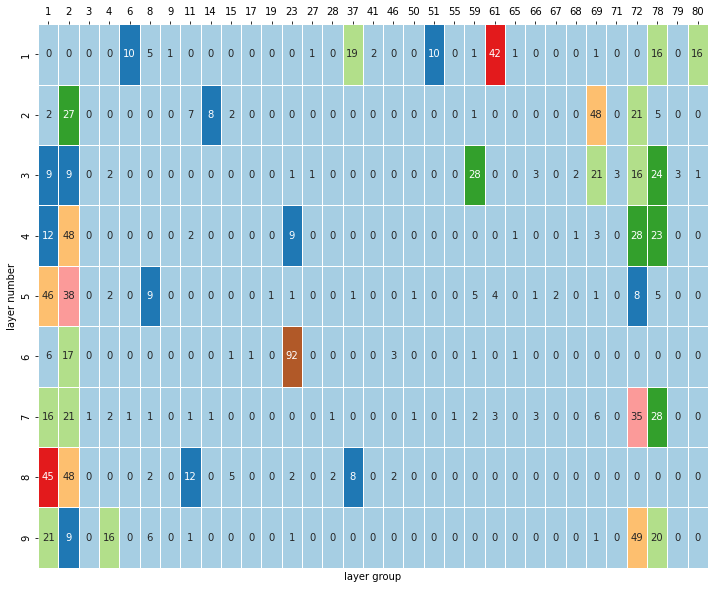

In [20]:
import seaborn as sns
import matplotlib.pylab as plt

# mask = np.zeros_like(df_label_lg)
# mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette("Paired")
ax = sns.heatmap(df_label_lg, linewidth=0.5, annot=True, cbar=False, cmap=cmap)
ax.set_ylabel("layer number")
ax.set_xlabel("layer group")
plt.show()